In [224]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [226]:
# Fetching S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

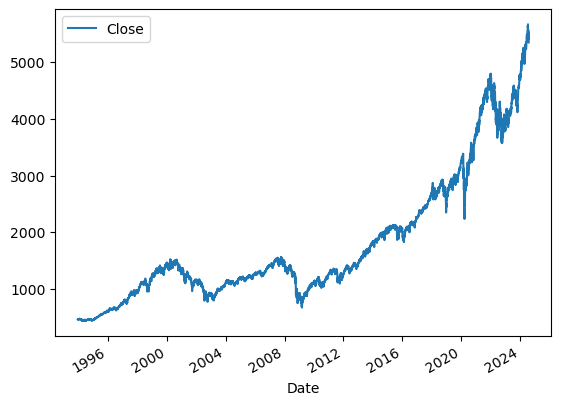

In [282]:
# Plotting the 'Close' price of S&P 500 over time
sp500.plot.line(y="Close", use_index=True)

In [238]:
# Display data's index
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-07-23 00:00:00-04:00', '2024-07-24 00:00:00-04:00',
               '2024-07-25 00:00:00-04:00', '2024-07-26 00:00:00-04:00',
               '2024-07-29 00:00:00-04:00', '2024-07-30 00:00:00-04:00',
               '2024-07-31 00:00:00-04:00', '2024-08-01 00:00:00-04:00',
               '2024-08-02 00:00:00-04:00', '2024-08-05 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24264, freq=None)

In [240]:
# Removing unnecessary columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [242]:
# Creating a 'Tomorrow' column by shifting 'Close' values by one day
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [244]:
# Creating a 'Target' column where 1 indicates the 'Close' price increased the next day, 0 otherwise
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [246]:
# Filtering data from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [248]:
# Initializing the Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# Splitting the data into training and testing sets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

# Defining predictor variables
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Fitting the model on the training data
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [250]:
# Making predictions on the test data
preds = model.predict(test[predictors])

In [252]:
# Converting predictions to a pandas Series and setting the index to match the test data
preds = pd.Series(preds, index=test.index)

In [254]:
# Calculating precision score of the predictions
precision_score(test["Target"], preds, zero_division=1)

0.5384615384615384

In [256]:
# Combining the actual target values and predictions into a single DataFrame
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

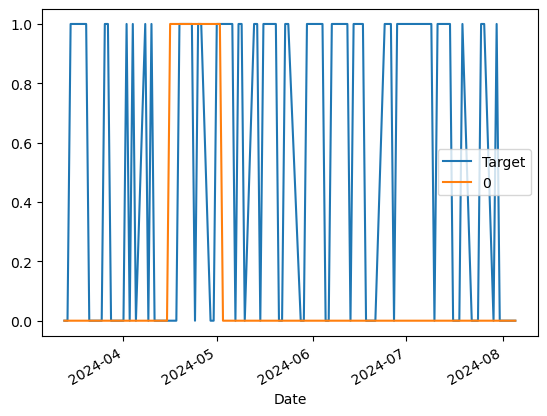

In [258]:
# Plotting the combined DataFrame
combined.plot()


In [260]:
# Defining a function to train the model and make predictions on the test data
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [262]:
# Defining a function to perform backtesting on the dataset
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    # Looping through the data in steps, creating training and test sets
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        print(f"Training from 0 to {i}, testing from {i} to {i+step}")
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [264]:
# Performing backtesting on the dataset
predictions = backtest(sp500, model, predictors)

Training from 0 to 2500, testing from 2500 to 2750
Training from 0 to 2750, testing from 2750 to 3000
Training from 0 to 3000, testing from 3000 to 3250
Training from 0 to 3250, testing from 3250 to 3500
Training from 0 to 3500, testing from 3500 to 3750
Training from 0 to 3750, testing from 3750 to 4000
Training from 0 to 4000, testing from 4000 to 4250
Training from 0 to 4250, testing from 4250 to 4500
Training from 0 to 4500, testing from 4500 to 4750
Training from 0 to 4750, testing from 4750 to 5000
Training from 0 to 5000, testing from 5000 to 5250
Training from 0 to 5250, testing from 5250 to 5500
Training from 0 to 5500, testing from 5500 to 5750
Training from 0 to 5750, testing from 5750 to 6000
Training from 0 to 6000, testing from 6000 to 6250
Training from 0 to 6250, testing from 6250 to 6500
Training from 0 to 6500, testing from 6500 to 6750
Training from 0 to 6750, testing from 6750 to 7000
Training from 0 to 7000, testing from 7000 to 7250
Training from 0 to 7250, testin

In [266]:
# Checking the distribution of predictions
predictions["Predictions"].value_counts()

Predictions
0    3618
1    2596
Name: count, dtype: int64

In [268]:
# Defining horizons for calculating rolling averages and trends
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

# Looping through each horizon to calculate new features
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500.loc[:, ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"trend_{horizon}"
    sp500.loc[:, trend_column] = sp500["Target"].shift(1).rolling(horizon).sum()

    new_predictors += [ratio_column, trend_column]

In [270]:
# Dropping rows with NaN values
sp500 = sp500.dropna()

In [272]:
# Re-initializing the Random Forest Classifier model with different parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [274]:
# Updating the predict function to use predict_proba for probability predictions
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [276]:
# Performing backtesting with the updated model and new predictors
predictions = backtest(sp500, model, new_predictors)

Training from 0 to 2500, testing from 2500 to 2750
Training from 0 to 2750, testing from 2750 to 3000
Training from 0 to 3000, testing from 3000 to 3250
Training from 0 to 3250, testing from 3250 to 3500
Training from 0 to 3500, testing from 3500 to 3750
Training from 0 to 3750, testing from 3750 to 4000
Training from 0 to 4000, testing from 4000 to 4250
Training from 0 to 4250, testing from 4250 to 4500
Training from 0 to 4500, testing from 4500 to 4750
Training from 0 to 4750, testing from 4750 to 5000
Training from 0 to 5000, testing from 5000 to 5250
Training from 0 to 5250, testing from 5250 to 5500
Training from 0 to 5500, testing from 5500 to 5750
Training from 0 to 5750, testing from 5750 to 6000
Training from 0 to 6000, testing from 6000 to 6250
Training from 0 to 6250, testing from 6250 to 6500
Training from 0 to 6500, testing from 6500 to 6750
Training from 0 to 6750, testing from 6750 to 7000
Training from 0 to 7000, testing from 7000 to 7250
Training from 0 to 7250, testin

In [286]:
# Checking the distribution of updated predictions
predictions["Predictions"].value_counts()

Predictions
0.0    4374
1.0     839
Name: count, dtype: int64

In [288]:
# Calculating precision score of the updated predictions
precision_score(predictions["Target"], predictions["Predictions"])

0.5744934445768772